# EDA

In [ ]:
#!pip install wordcloud

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Диалоги в csv разделены пустой строкой
data = pd.read_csv('data/simpsons_dataset.csv')
data.head(10)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
5,Martin Prince,I don't think there's anything left to say.
6,Edna Krabappel-Flanders,Bart?
7,Bart Simpson,Victory party under the slide!
8,NaN,NaN
9,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!


In [3]:
# Посчитаем количество реплик на одного персонажа
data[~data['spoken_words'].isna()].groupby('raw_character_text').count().sort_values(by= 'spoken_words', ascending=False).head(5)

,spoken_words
raw_character_text,
Homer Simpson,27850
Marge Simpson,13172
Bart Simpson,12995
Lisa Simpson,10756
C. Montgomery Burns,3077


## Построим облако слов Гомера

In [6]:
homer_data = data[(data['raw_character_text']=='Homer Simpson') & (~data['spoken_words'].isna())]

In [8]:
homer_text = " ".join([str(phrase) for phrase in homer_data.spoken_words]).lower()
homer_mask = np.array(Image.open("app/static/images/homer_mask.png"))

In [9]:
stopwords = set(STOPWORDS)
stopwords.update(["marge", "bart", "lisa"])

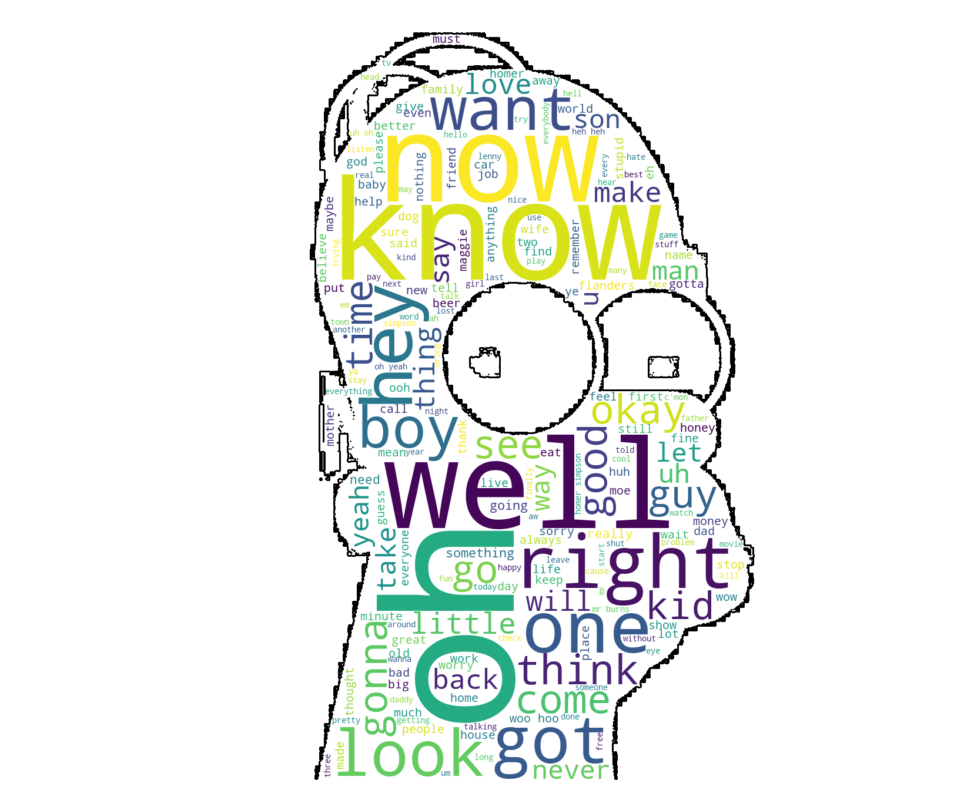

In [10]:
wordcloud = WordCloud(
    #max_font_size=50,
    max_words=200,
    stopwords=stopwords,
    background_color="white",
    mask=homer_mask,
    contour_width=2,
    contour_color="black")

wordcloud.generate(homer_text)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('app/static/images/homer_word_cloud.png')
plt.show()

# Топ фраз Гомера

In [90]:
homer_phrases = data[(~data['spoken_words'].isna()) & (data['raw_character_text']=='Homer Simpson')]
homer_phrases_list = list()
for ph in homer_phrases['spoken_words']:
     ph = ph.replace('"', '').replace('-', '').replace('/', '')
     if len(ph.split('[.?!]')) > 1:
          homer_phrases_list.append(' '.join(ph.split()))
     ph = ph.split('[.?!]')
     ph = [' '.join(p.strip().split()) for p in ph] # Удалим лишние пробелы
     ph = [p  for p in ph  if len(p) > 1]
     homer_phrases_list.extend(ph)
     

In [91]:
homer_phrases_df = pd.DataFrame.from_dict(Counter(homer_phrases_list), orient='index').reset_index()
homer_phrases_df.columns = ['phrase', 'cnt']

In [92]:
len(homer_phrases_df) # 40539 -> 39430 -> 39395 -> 52237 -> 52176 -> 25954 -> 25951

25951

In [93]:
homer_phrases_df.sort_values(by= 'cnt', ascending=False).head(30)

,phrase,cnt
496,Woo hoo!,109
38,No.,67
220,Okay.,56
102,Huh?,51
440,What?,40
476,Why you little...,39
550,Uhoh.,37
92,Sorry.,30
605,No!,28
2,Oh.,27


In [94]:
homer_phrases_df.sort_values(by= 'cnt', ascending=True).head(30)

,phrase,cnt
0,Never thrown a party? What about that big bash...,1
17274,Or we could just resolve to be more careful wi...,1
17273,I'll just focus on one area... How many did I ...,1
17272,Uhhuh... uhhuh...,1
17271,This ends now!,1
17270,EZ Blo...,1
17269,"Oh, I get it. These are those trick candles yo...",1
17268,"I don't have to make a wish, because I already...",1
17267,Where is he? I know he's in here.,1
17266,Where is he? Where is he? I smell his aftershave!,1


# Experiment data preparation stap

In [18]:
def prepare_data(raw_df: pd.DataFrame) -> list:
    context = list()
    dataset = list()
    for _, row in raw_df.iterrows():
        charachter, phrase = row['raw_character_text'], row['spoken_words']
        if not isinstance(charachter, str):
            context = list()
        elif len(context)>0:
            item = {
                'prompt': context[-1],
                'response': 'UNK' if not isinstance(phrase, str) else phrase,
                'context': context[:-2] if len(context) < 10 else context[-10 :-2],
                'label': 1 if charachter == 'Homer Simpson' else 0
            }
            dataset.append(item)
            if len(context[-1].split(".?!")) > 1:
                item_2 = {
                    'prompt': context[-1].split(".?!")[-1],
                    'response': 'UNK' if not isinstance(phrase, str) else phrase.split(".?!")[0],
                    'context': context[:-2] if len(context) < 10 else context[-10 :-2],
                    'label': 1 if charachter == 'Homer Simpson' else 0
                }
                dataset.append(item_2)
            context.append('UNK' if not isinstance(phrase, str) else phrase)
        else:
            context.append('UNK' if not isinstance(phrase, str) else phrase)
    return dataset

In [19]:
dataset = prepare_data(raw_df=data)